In [190]:
#!pip install pybaseball
from pybaseball import batting_stats
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [191]:
#importing data
#df_bat = batting_stats(2021,2026)

In [192]:
#converting to pickle for easier access
#df_bat.to_pickle("batting_stats_2021_2026.pkl")

In [193]:
#loading pickle
df_bat_load = pd.read_pickle("batting_stats_2021_2026.pkl")

In [194]:
#grouping by id and filtering for all players with at least 1 full season
df_bat_load = df_bat_load.groupby('IDfg', group_keys=False).filter(lambda x: len(x) >= 1)

In [195]:
#creating a next season WAR target variable
def next_season_stats(player):
  player = player.sort_values("Season")
  player['Next_Szn_War'] = player['WAR'].shift(-1)
  return player

df_bat_load = df_bat_load.groupby('IDfg', group_keys=False).apply(next_season_stats)

/tmp/ipython-input-2015820716.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bat_load = df_bat_load.groupby('IDfg', group_keys=False).apply(next_season_stats)


In [196]:
#grabbing all null columns
null_cols = df_bat_load.isnull().sum()

In [197]:
#filtering out null columns
complete_cols = list(df_bat_load.columns[null_cols == 0])

In [198]:
#merging complete columns and created target variable
df_bat_load = df_bat_load[complete_cols + ['Next_Szn_War']].copy()

In [199]:
#renaming dataframe
batting = df_bat_load

In [200]:
#analyzing columns that are object type
batting.dtypes[batting.dtypes == 'object']

,0
Name,object
Team,object
Dol,object
Age Rng,object


In [201]:
#deleting dol column as it is not needed
del batting['Dol']

In [202]:
#deleting age rng column as it is not needed
del batting['Age Rng']

In [203]:
#creating team code column to quantify the team a player is on
batting['Team_Code'] = batting['Team'].astype('category').cat.codes

In [204]:
#creating a copy of dataframe
batting_copy = batting.copy()

In [205]:
#creating model, time series split, and sequential feature selector
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model = Ridge(alpha = 3)

split = TimeSeriesSplit(n_splits = 3)

feature_selector = SequentialFeatureSelector(model, n_features_to_select=20,
                                     direction = 'forward', cv = split,
                                     n_jobs = 4)

In [206]:
#removing columns that arent going to be used for prediction
removed_cols = ['Next_Szn_War', 'Name', 'Team', 'IDfg', 'Season']
selected_cols = batting.columns[~batting.columns.isin(removed_cols)]

In [234]:
#scaling data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

batting.loc[:, selected_cols] = scaler.fit_transform(batting[selected_cols]);
batting;

In [208]:
#creating training data and selecting features based on training data
train_rows = batting.dropna(subset=['Next_Szn_War'])

x_train = train_rows[selected_cols]
y_train = train_rows['Next_Szn_War']

feature_selector.fit(x_train, y_train)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=Ridge(alpha=3), n_features_to_select=20,
                          n_jobs=4)

In [209]:
#getting list of predictors from feature selection
predictors = list(selected_cols[feature_selector.get_support()])

In [210]:
#creating rolling backtest of model, trains on all prior seasons and predicts next season war
#returns actual vs. predicted values for each season.
def backtest(data, model, predictors, start=1, step=1):
  all_predictions = []

  years = sorted(data['Season'].unique())

  for i in range(start, len(years), step):
    current_year = years[i]

    train = data[data['Season'] < current_year].dropna(subset=['Next_Szn_War'])
    test = data[data['Season'] == current_year]

    model.fit(train[predictors], train['Next_Szn_War'])

    predictions = model.predict(test[predictors].fillna(0))
    predictions = pd.Series(predictions, index = test.index)
    combined = pd.concat([test['Next_Szn_War'], predictions], axis = 1)
    combined.columns = ['Actual', 'Predicted']

    all_predictions.append(combined)
  return pd.concat(all_predictions)


In [211]:
#making predictions and dropping na values
predictions = backtest(batting, model, predictors)
predictions = predictions.dropna(subset=['Actual', 'Predicted'])

In [212]:
#finding rmse from mse
from sklearn.metrics import mean_squared_error

print("RMSE: ", (mean_squared_error(predictions['Actual'], predictions['Predicted']))**.5)

RMSE:  1.6023441767615807


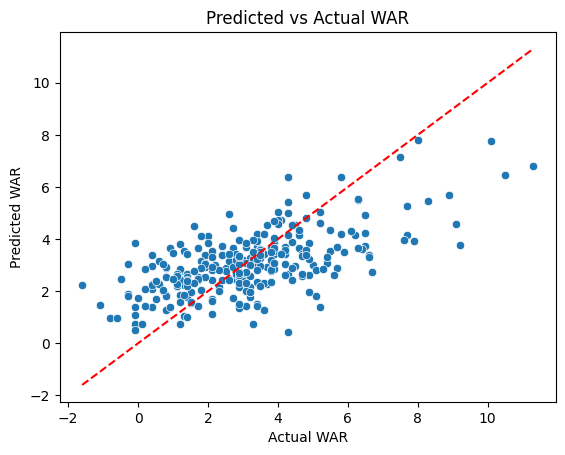

In [213]:
#creating scatterplot of predicted vs actual war
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='Actual', y='Predicted', data=predictions)
plt.plot([predictions['Actual'].min(), predictions['Actual'].max()],
         [predictions['Actual'].min(), predictions['Actual'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual WAR')
plt.ylabel('Predicted WAR')
plt.title('Predicted vs Actual WAR')
plt.show()

In [242]:
def player_history(df):
    df = df.sort_values('Season')

    df['Career_Season'] = range(df.shape[0])

    corr = df[['Career_Season', 'WAR']].expanding().corr()
    df['War_Correlation'] = corr.xs('WAR', level=1)['Career_Season'].fillna(1).values

    df['War_Difference'] = df['WAR'] / df['WAR'].shift(1)
    df['War_Difference'] = df['War_Difference'].fillna(1)
    df.loc[df['War_Difference'].isin([np.inf, -np.inf]), 'War_Difference'] = 1

    return df

batting = batting.groupby('IDfg', group_keys=False).apply(player_history);

/tmp/ipython-input-1636753826.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batting = batting.groupby('IDfg', group_keys=False).apply(player_history);


In [215]:
#function to returh player's war relative to average war
def group_averages(df):
  return df['WAR'] / df['WAR'].mean()

In [216]:
#calculates each player's war relative to the average war for number season in dataset and assigns it to a new column 'War_Season'
batting['War_Season'] = batting.groupby('Career_Season', group_keys = False).apply(group_averages)

/tmp/ipython-input-608940061.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batting['War_Season'] = batting.groupby('Career_Season', group_keys = False).apply(group_averages)


In [217]:
#new list of predictors including war trends
new_predictors = predictors + ['Career_Season', 'War_Correlation', 'War_Season', 'War_Difference']

In [218]:
#utilizing backtest function on new predictors to see if they improve rmse
new_predictions = backtest(batting, model, new_predictors)
new_predictions = new_predictions.dropna(subset=['Actual', 'Predicted'])

In [219]:
#did not improve rmse
((mean_squared_error(new_predictions['Actual'], new_predictions['Predicted']))**.5)

1.6303283294613364

In [220]:
#seeing how new predictors influence next season war
pd.Series(model.coef_, index = new_predictors).sort_values()


,0
Age,-1.365020
BABIP,-1.047992
vKC (sc),-0.595408
War_Difference,-0.159600
War_Correlation,-0.150270
Career_Season,0.016753
wSF/C,0.413157
WAR,0.567203
SB,0.583109
RAR,0.616511


In [221]:
#calculating difference in war
diff = predictions['Actual'] - predictions['Predicted']

In [222]:
#merging predictions with batting df to calculate actual vs predicted
merged_predictions = predictions.merge(batting, left_index = True, right_index = True)

In [223]:
#calculating actual vs predicted
merged_predictions['Actual_War_Difference'] = (predictions['Actual'] - predictions['Predicted']).abs()

In [224]:
#renaming columns for clarity
merged_predictions.rename(columns={'Predicted': 'Next_Szn_War_Prediction'}, inplace=True)

In [225]:
#cleaning up predictions for clarity
merged_predictions_cols = merged_predictions[['IDfg', 'Season',  'Name',  'Next_Szn_War_Prediction', 'Next_Szn_War', 'Actual_War_Difference']].sort_values(['Actual_War_Difference'])
merged_predictions
merged_preds_df = pd.DataFrame(merged_predictions_cols.head(10))
merged_preds_df['Next_Szn_War_Prediction'] = merged_preds_df['Next_Szn_War_Prediction'].round(1)
merged_preds_df['Actual_War_Difference'] = merged_preds_df['Actual_War_Difference'].round(1)

In [226]:
#viewing predictions based on the highest projected next season war
merged_predictions_cols.sort_values(['Next_Szn_War_Prediction'], ascending = False)

,IDfg,Season,Name,Next_Szn_War_Prediction,Next_Szn_War,Actual_War_Difference
17,25764,2024,Bobby Witt Jr.,7.803718,8.0,0.196282
0,15640,2024,Aaron Judge,7.772189,10.1,2.327811
5,19755,2024,Shohei Ohtani,7.151793,7.5,0.348207
2,15640,2022,Aaron Judge,6.817941,11.3,4.482059
237,25764,2023,Bobby Witt Jr.,6.469485,10.5,4.030515
...,...,...,...,...,...,...
427,26197,2023,Andrew Vaughn,0.734440,-0.1,0.834440
582,7304,2023,Salvador Perez,0.728416,3.3,2.571584
213,5235,2023,Justin Turner,0.721884,1.2,0.478116
394,9847,2024,Andrew McCutchen,0.522002,-0.1,0.622002


In [227]:
#making predictions for 2026 utilizing original set of predictors

train = batting.dropna(subset=['Next_Szn_War']).copy()
model.fit(train[predictors], train['Next_Szn_War'])

Ridge(alpha=3)

In [228]:
#creating code to take user input to find 2026 predicted war for given player
player_name = input("Enter player name to predict 2026 WAR: ").strip()

player_rows = batting[batting['Name'].str.lower() == player_name.lower()]

future_row = player_rows[player_rows['Season'] == 2025]

if player_rows.empty:
    print(f"No data for {player_name}. Cannot predict 2026 WAR.")
else:
    future_row = player_rows.sort_values('Season', ascending=False).head(1)

    pred = model.predict(future_row[predictors])[0]

    last_season = future_row['Season'].values[0]
    gap = 2026 - last_season - 1

    decay_factor = 0.9 ** gap
    adjusted_pred = pred * decay_factor

    print(f"Predicted WAR for {player_name} in 2026: {adjusted_pred:.1f}")
    if gap >= 1:
       print("Last full season was: ", last_season)
       print("War decayed by: ", (pred - adjusted_pred).round(1))

Enter player name to predict 2026 WAR: aaron judge
Predicted WAR for aaron judge in 2026: 7.6


In [229]:
#creating dataframe of 2026 predictions
latest_stats = batting.sort_values('Career_Season').groupby('Name').tail(1)

latest_stats['Predicted_WAR'] = model.predict(latest_stats[predictors])

latest_stats['Gap'] = 2026 - latest_stats['Season'] - 1
latest_stats['Decay_Factor'] = 0.9 ** latest_stats['Gap']
latest_stats['Predicted_WAR'] *= latest_stats['Decay_Factor']


predictions_df = latest_stats[['Name', 'Season', 'Predicted_WAR']]
predictions_df['Season'] = 2026
predictions_df['Predicted_WAR'] = predictions_df['Predicted_WAR'].round(1)
predictions_df.sort_values(['Predicted_WAR'], ascending=False).head(10)

/tmp/ipython-input-2117908483.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df['Season'] = 2026
/tmp/ipython-input-2117908483.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df['Predicted_WAR'] = predictions_df['Predicted_WAR'].round(1)


,Name,Season,Predicted_WAR
1,Aaron Judge,2026,7.6
29,Cal Raleigh,2026,7.1
119,Bobby Witt Jr.,2026,6.8
34,Juan Soto,2026,6.6
6,Ronald Acuna Jr.,2026,6.5
13,Shohei Ohtani,2026,6.5
62,Corbin Carroll,2026,6.0
121,Jose Ramirez,2026,5.9
66,Geraldo Perdomo,2026,5.7
152,Fernando Tatis Jr.,2026,5.4


In [230]:
#creating dataframe of selected features
features_selected = pd.Series(model.coef_, index = predictors).sort_values()

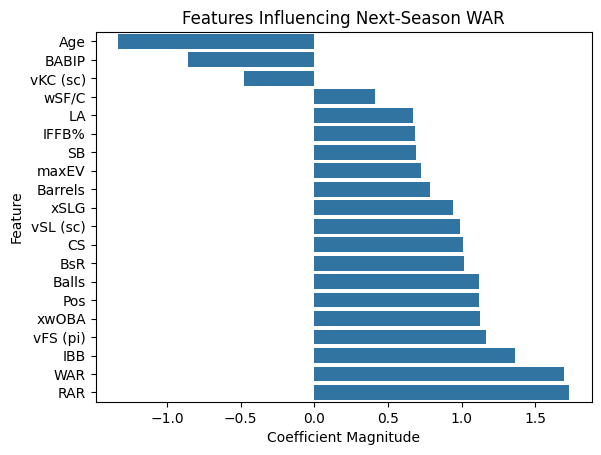

In [231]:
#creating a feature importance horizontal bar chart
sns.barplot(x=features_selected.values, y=features_selected.index)
plt.title('Features Influencing Next-Season WAR')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.show()

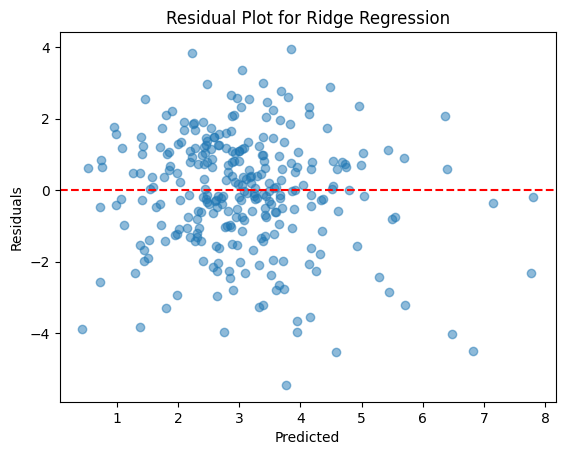

In [232]:
#creating a residual vs predicted plot for further analysis
residuals = merged_predictions_cols['Next_Szn_War_Prediction'] - merged_predictions_cols['Next_Szn_War']
plt.scatter(merged_predictions_cols['Next_Szn_War_Prediction'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot for Ridge Regression")
plt.show()